# Pre-Work

As a first step, import some of the libraries we will be using in the course. This will test that everything is installed correctly on your system. Running the cell below should not return errors.

In [1]:
import numpy as np
import scipy as sp
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
import pymc3 as pm
import sklearn as sk
import seaborn as sns

print('All packages imported successfully!')

All packages imported successfully!


If everything was imported, you are ready to work through the exercises below.

## Data Import and Manipulation

Loading and processing data has become easier since the development of the `pandas` library, which provides data structures and functions for automating key data operations. 

For importing data from most common storage formats, several `read_*` functions are available.

In [2]:
[f for f in dir(pd) if f.startswith('read_')]

['read_clipboard',
 'read_csv',
 'read_excel',
 'read_feather',
 'read_fwf',
 'read_gbq',
 'read_hdf',
 'read_html',
 'read_json',
 'read_msgpack',
 'read_parquet',
 'read_pickle',
 'read_sas',
 'read_spss',
 'read_sql',
 'read_sql_query',
 'read_sql_table',
 'read_stata',
 'read_table']

The `../data/` subdirectory includes some clinical trial data in `cdystonia.csv`. Choose the appropriate function and use it to import this data to a variable called `cdystonia`. Print the first 15 lines of the resulting `DataFrame`.

In [8]:
# Choose the appropriate function to read `../data/cdystonia.csv` into a variable called `cdystonia`
# Print the first 15 lines of the `DataFrame` `cdystonia`
fpath_data = '../data/cdystonia.csv'
# !head '../data/cdystonia.csv'
cdystonia = pd.read_csv(fpath_data)
cdystonia[0:15]

,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24
3,1,4,8,1,1,5000U,65,F,37
4,1,5,12,1,1,5000U,65,F,39
5,1,6,16,1,1,5000U,65,F,36
6,2,1,0,1,2,10000U,70,F,60
7,2,2,2,1,2,10000U,70,F,26
8,2,3,4,1,2,10000U,70,F,27
9,2,4,8,1,2,10000U,70,F,41


This dataset is from [Statistical Methods for the Analysis of Repeated Measurements](http://www.amazon.com/Statistical-Methods-Analysis-Repeated-Measurements/dp/0387953701) by Charles S. Davis, pp. 161-163 (Springer, 2002). These data are from a multicenter, randomized controlled trial of botulinum toxin type B (BotB) in patients with cervical dystonia from nine U.S. sites.

Patients were randomized to placebo (N=36), 5000 units of BotB (N=36), or 10,000 units of BotB (N=37). The response variable is the total score on Toronto Western Spasmodic Torticollis Rating Scale (TWSTRS), measuring severity, pain, and disability of cervical dystonia (high scores mean more impairment). TWSTRS was measured at baseline (week 0) and weeks 2, 4, 8, 12, 16 after treatment began, so this is a longitudinal study.

1. Since there are repeated measures of each patient, the `patient` column alone cannot be used as an index, because it is not unique. Use some of the columns in the DataFrame to create an index for the data that is unique.

In [9]:
# Choose a column in addition to "patient" so that the two columns have unique values, and set those two to be the index.
cols_to_try = [['patient'], ['patient','obs'], ['patient', 'week'], ['patient', 'id'], ['patient', 'site'], ['id', 'obs'], ['id', 'week'], ['id', 'site', 'obs']]
print('Uniqueness:')
for cols in cols_to_try:
    print(f"\t{cols}: \t{not cdystonia.reset_index()[cols].duplicated().any()}")
    
# Choose patient/week because it's intuitive and because we want to use week in the next stage
cdystonia = cdystonia.reset_index(drop=True).set_index(['patient','week'])

Uniqueness:
	['patient']: 	False
	['patient', 'obs']: 	True
	['patient', 'week']: 	True
	['patient', 'id']: 	False
	['patient', 'site']: 	False
	['id', 'obs']: 	False
	['id', 'week']: 	False
	['id', 'site', 'obs']: 	True


2. The `cdystonia` dataset is stored in **long** format, meaning that each row contains a single observation. Use pandas functions and methods to change the data to **wide** format, where each row represents the data for a single patient. 

In [20]:
# Convert the data to a wide format, where each row represents the data for a single patient
# want:
# patient, site?, treat, age, sex, twstrs0, twstrs2, ..., twstrs16

# First, widen the result column by unstacking by week
w_cdystonia_outcomes = cdystonia['twstrs'].unstack('week').rename(columns=lambda x: f'twstrs_{x:d}')

# Then extract the features per-patient - first ensuring that they're all static for a patient:
# i.e. ensure that all patient features are per patient, not to the observation:
patient_level_gb = cdystonia.drop(columns=['obs', 'twstrs']).groupby(level='patient')

In [22]:
assert (patient_level_gb.nunique() == 1).all().all()

# Now get the features per-patient by just taking the first for each...
patient_features = patient_level_gb.first()

# And finally, join the results to the features:
w_cdystonia = w_cdystonia_outcomes.join(patient_features)
assert cdystonia.reset_index()['patient'].nunique() == len(w_cdystonia)
w_cdystonia

,twstrs_0,twstrs_2,twstrs_4,twstrs_8,twstrs_12,twstrs_16,site,id,treat,age,sex
patient,,,,,,,,,,,
1,32.0,30.0,24.0,37.0,39.0,36.0,1,1,5000U,65,F
2,60.0,26.0,27.0,41.0,65.0,67.0,1,2,10000U,70,F
3,44.0,20.0,23.0,26.0,35.0,35.0,1,3,5000U,64,F
4,53.0,61.0,64.0,62.0,NaN,NaN,1,4,Placebo,59,F
5,53.0,35.0,48.0,49.0,41.0,51.0,1,5,10000U,76,F
...,...,...,...,...,...,...,...,...,...,...,...
105,45.0,46.0,33.0,44.0,46.0,48.0,9,7,Placebo,79,F
106,67.0,63.0,71.0,66.0,68.0,71.0,9,8,5000U,43,M
107,57.0,NaN,36.0,23.0,NaN,52.0,9,9,10000U,50,M


3. To get an idea about the efficacy of the treatment, use `pandas` to group the data by treatment group, and calculate the mean and standard deviation of the `twstrs` outcome variable for each group in week 4.

In [23]:
# group the data by treatment group, and calculate the mean and standard deviation of the `twstrs` outcome variable for each group in week 4.
# As a sanity check, this should be the answer here:

#                mean       std
# treat
# 10000U         34.805556  12.188565
# 5000U          37.114286  15.311993
# Placebo        39.342857  11.827045

w_cdystonia.groupby('treat')['twstrs_4'].agg(['mean', 'std'])

,mean,std
treat,,
10000U,34.805556,12.188565
5000U,37.114286,15.311993
Placebo,39.342857,11.827045


4. Since this is a longitudinal study, graphics are helpful for understanding the dynamics of the experiment. Using the plotting package of your choice (there are many for Python!) create a set of plots showing how the response variable changes over time for each experimental group. 

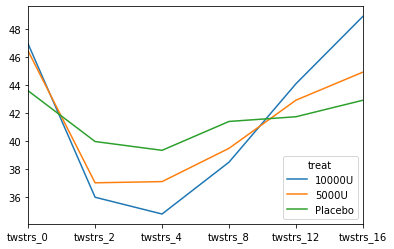

In [24]:
# create a set of plots showing how the response variable changes over time for each experimental group
df = w_cdystonia.groupby('treat')[[c for c in w_cdystonia.columns if c.startswith('twstrs')]].mean().T#agg(['mean', 'std'])
df.plot()

## Linear Algebra


Operations become much faster when we can express them as vectorized linear algebra commands. One example is generating multivariate normal distributions.

Suppose we wish to generate samples with mean $\mu$ and covariance $\Sigma$, where $\mu$ is $n \times 1$ and $\Sigma$ is $n \times n$. One way to do this is to calculate a [*Cholesky decomposition*](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\Sigma$, so that
$$
\Sigma = LL^T.
$$

Then if $x$ is $n$ independent draws from a standard normal distribution, 
$$
\nu = Lx + \mu \sim \mathcal{N}(\mu, \Sigma)
$$

### Exercises
Let 
$$
\mu = (3, 2)
$$
and
$$
\Sigma = \left(\begin{array}{cc}
1 & 0.9 \\
0.9 & 1
\end{array}\right)
$$

1. Use `np.linalg.cholesky` to compute $L$, the Cholesky decomposition of $\Sigma$
2. In newer Python (3.6+), `@` is matrix multiplication. Confirm that $\Sigma = LL^T$.
3. Draw 2 independent draws from a standard normal using `x = np.random.randn(2)`, and compute $\nu$ using `L @ x + mu`
4. The above exercise generates 1 draw from a multivariate normal. Use `x = np.random.randn(2, 1_000)` and the same formula as above to generate 1,000 draws.

In [26]:
mu = np.array([[3], [2]])
sigma = np.array([[1, 0.9], [0.9, 1]])

In [45]:
# Use `np.linalg.cholesky` to compute $L$, the Cholesky decomposition of `sigma`
L = np.linalg.cholesky(sigma)
L

array([[1.        , 0.        ],
       [0.9       , 0.43588989]])

In [46]:
# In newer Python (3.6+), `@` is matrix multiplication. Confirm that `sigma = L @ L.T`
assert (L @ L.T == sigma).all()

In [47]:
# Draw 2 independent draws from a standard normal using `x = np.random.randn(2)`, and compute `nu` using `L @ x + mu`
x = np.random.randn(2)
print(x)
nu = L @ x + mu
print(nu)

[-0.34001977  0.68367915]
[[2.65998023 2.99199104]
 [1.65998023 1.99199104]]


In [48]:
# The above exercise generates 1 draw from a multivariate normal. Use `x = np.random.randn(2, 1_000)` and the same formula as above to generate 1,000 draws
x = np.random.randn(2, 1000)
nu = L @ x + mu
nu.shape

(2, 1000)

# begin sidetrack

In [33]:
sigma

array([[1. , 0.9],
       [0.9, 1. ]])

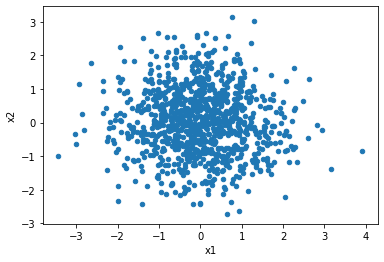

In [43]:
df_ind = pd.DataFrame(np.random.randn(2, 1000).T, columns=['x1', 'x2'])
df_ind.plot.scatter(x='x1', y='x2')

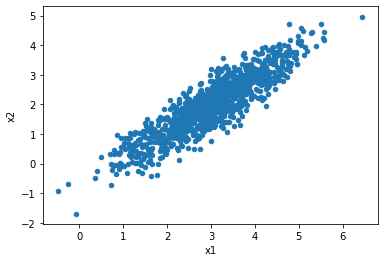

In [49]:
nu = L @ np.random.randn(2, 1000) + mu
df_cov = pd.DataFrame(nu.T, columns=['x1', 'x2'])
df_cov.plot.scatter(x='x1', y='x2')

# end sidetrack

## Probability Distributions and Simulation

Bayesian inference relies on the use of probability distributions for constructing models. Though several statistical and machine learning packages implement their own set of probability distributions, the NumPy and SciPy libraries include general-purpose functions and classes for performing probability operations. 

NumPy has an efficient set of random number generators for different distributions, while SciPy implements a large set of complete probability distributions that allow them to be used in most applications.

In [50]:
from scipy.stats import distributions as dists

In [51]:
dir(dists)[-20:]

['truncnorm_gen',
 'tukeylambda',
 'tukeylambda_gen',
 'uniform',
 'uniform_gen',
 'vonmises',
 'vonmises_gen',
 'vonmises_line',
 'wald',
 'wald_gen',
 'weibull_max',
 'weibull_max_gen',
 'weibull_min',
 'weibull_min_gen',
 'wrapcauchy',
 'wrapcauchy_gen',
 'yulesimon',
 'yulesimon_gen',
 'zipf',
 'zipf_gen']

Let's look at a gamma distribution as an example:

In [52]:
gamma_dist = dists.gamma

Inspecting the attributes of `gamma_dist`, we can see several important methods, including `pdf` (probability distribution function), `cdf` (cumulative distribution function), `rvs` (random number generator), and more.

In [53]:
[f for f in dir(gamma_dist) if not f.startswith('_')]

['a',
 'b',
 'badvalue',
 'cdf',
 'entropy',
 'expect',
 'extradoc',
 'fit',
 'fit_loc_scale',
 'freeze',
 'generic_moment',
 'interval',
 'isf',
 'logcdf',
 'logpdf',
 'logsf',
 'mean',
 'median',
 'moment',
 'moment_type',
 'name',
 'nnlf',
 'numargs',
 'pdf',
 'ppf',
 'random_state',
 'rvs',
 'sf',
 'shapes',
 'stats',
 'std',
 'support',
 'var',
 'vecentropy',
 'xtol']

### Exercise: Simulating linear regression

1. Generate a (1000, 10) `features` array using a uniform distribution.
2. Generate a (10, 1) `weights` array, using a normal distribution with standard deviation 2 and mean 0. Note this is typically unobserved.
3. Generate a (1000, 1) `noise` array, using a normal distribution with standard deviation 1 and mean 0. Note that this is typically unobserved.
4. Compute (1000, 1) `target` array, as `features @ weights + noise`
5. Recover an estimate for the weights using `np.linalg.pinv(features) @ target` (`pinv` is the [Moore-Penrose pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse))
6. Our statistical model is 
$$
\text{weights} \sim \mathcal{N}(0, 2) \\
\text{target} | \text{features}, \text{weights} \sim \mathcal{N}(\text{features} \cdot \text{weights}, 1)
$$
What is the log probability that all the weights are 0, and all the targets are 1, given your generated `features`?
7. What is the log probability of your generated `weights` and generated `targets`, given your generated `features`?

In [86]:
# Generate a (1000, 10) `features` array using a uniform distribution.
features = dists.uniform().rvs(size=(1000, 10))
assert features.shape == (1000, 10)

In [87]:
# Generate a (10, 1) `weights` array, using a normal distribution with standard deviation 2 and mean 0
weights = dists.norm(loc=0, scale=2).rvs((10, 1))
assert weights.shape == (10, 1)

In [88]:
# Generate a (1000, 1) `noise` array, using a normal distribution with standard deviation 1 and mean 0
noise = dists.norm(loc=0, scale=1).rvs((1000, 1))
assert noise.shape == (1000, 1)

In [89]:
# Compute (1000, 1) `target` array, as `features @ weights + noise`
target = features @ weights + noise
assert target.shape == (1000, 1)

In [91]:
# Recover an estimate for the weights using `np.linalg.pinv(features) @ target`
weight_est = np.linalg.pinv(features) @ target
assert weight_est.shape == (10, 1)

In [73]:
weights

array([[-0.12534781],
       [-3.88944986],
       [-1.8846357 ],
       [ 3.59131765],
       [-5.05084538],
       [ 2.03755973],
       [-2.68678186],
       [-0.22403035],
       [-0.24978183],
       [ 0.70270194]])

In [74]:
weight_est

array([[-0.0745146 ],
       [-3.7918562 ],
       [-1.91124605],
       [ 3.56494746],
       [-5.10630334],
       [ 2.05713089],
       [-2.77119104],
       [-0.25923472],
       [-0.03895138],
       [ 0.53061587]])

In [119]:
# Compute the log probability that all the weights are 0, and all the targets are 1, given your generated `features`

# I dont quite understand this, probably because I'm taking some of it too literally: 
# 1. all quantities are continuous, so the probability that they take on any particular value is 0... So I assume that what they're asking for is the log probability *density*
# 2. weights are not related to targets or features... so what does the 'given generated features' mean for the first? 
#    - I assume that this is asking for the probability density of the target distribution at target=1, at the point at which weights are 0 and the features are as generated above...

rv_weights = dists.norm(loc=0, scale=2)
logp_weights_0 = rv_weights.logpdf(np.zeros(weights.shape))
print(f'logp_weights_0.sum() = {logp_weights_0.sum()}')

rv_conditioned_target_weights0 = dists.norm(loc=0, scale=1) # given weights are 0
logp_targets_1 = rv_conditioned_target_weights0.logpdf(np.ones(target.shape))
print(f'logp_targets_1.sum() = {logp_targets_1.sum()}')


logp_total = logp_weights_0.sum() + logp_targets_1.sum()
print(f'logp_total.sum()     = {logp_total.sum()} (p_total: {np.exp(logp_total.sum()):0.15f})')


logp_weights_0.sum() = -16.12085713764618
logp_targets_1.sum() = -1418.938533204673
logp_total.sum()     = -1435.0593903423191 (0.000000000000000)


In [145]:
# Compute the log probability of your generated `weights` and `targets`, given your generated `features`

# This here is assuming the target dist is static across features, which is patently untrue
if False:
    logp_weights_gen = rv_weights.logpdf(weights)
    print(f'logp_weights_gen.sum() = {logp_weights_gen.sum()}')

    rv_conditioned_target = dists.norm(loc=features.mean(axis=0) @ weights, scale=1)
    logp_targets_gen = rv_conditioned_target.logpdf(target)
    print(f'logp_targets_gen.sum() = {logp_targets_gen.sum()}')

    #
    logp_total_gen = logp_weights_gen.sum() + logp_targets_gen.sum()
    print(f'logp_total_gen.sum()     = {logp_total_gen.sum()} (p_total_gen: {np.exp(logp_total_gen.sum()):0.15f})')


In [146]:
# Compute the log probability of your generated `weights` and `targets`, given your generated `features`

logp_weights_gen = rv_weights.logpdf(weights)
print(f'logp_weights_gen.sum() = {logp_weights_gen.sum()}')

# compute separate distribution for each feature value
logp_targets_gen = np.ones(target.shape) * np.nan
for ii, ff in enumerate(features):
    frv_conditioned_target = dists.norm(loc=ff @ weights, scale=1)
    logp_targets_gen[ii] = rv_conditioned_target.logpdf(target[ii])
print(f'logp_targets_gen.sum() = {logp_targets_gen.sum()}')

#
logp_total_gen = logp_weights_gen.sum() + logp_targets_gen.sum()
print(f'logp_total_gen.sum()     = {logp_total_gen.sum()} (p_total_gen: {np.exp(logp_total_gen.sum()):0.15f})')


logp_weights_gen.sum() = -25.108906125602417
logp_targets_gen.sum() = -4454.928193428217
logp_total_gen.sum()     = -4480.03709955382 (p_total_gen: 0.000000000000000)


Your answer to 5 above should match the answer `scikit-learn` provides:

In [108]:
from sklearn.linear_model import LinearRegression

sk_model = LinearRegression(fit_intercept=False).fit(features, target)

assert (np.abs((sk_model.coef_.T - weight_est)) < 10e-15).all()

## Optimisation

Another way of running linear regression is via optimization. Suppose we want to minimize the sum of squares using scipy. We can do this using `scipy.optimize`.

In [137]:
from scipy.optimize import fmin_bfgs

features = np.random.uniform(size=(1000, 10))
weights = np.random.normal(0, 2, size=(10, 1))
noise = np.random.normal(0, 1, size=(1000, 1))
target = (features @ weights + noise).flatten()

## Exercise: Optimization

Find the weights with the least mean squared error using `fmin_bfgs`. It expects a function to minimize and an initial point.

1. The function to minimize should accept an argument `x`, and return `((features @ x - target) ** 2).mean()`
2. You can initialize with a vector of 10 zeros.

In [138]:
# Write the function to minimize, and an initial point

def loss_function(x):
    return ((features @ x - target) ** 2).mean()

initial_point = np.zeros(10)

assert initial_point.shape == (10,)

In [139]:
min_x = fmin_bfgs(loss_function, initial_point)
min_x

Optimization terminated successfully.
         Current function value: 1.016107
         Iterations: 16
         Function evaluations: 204
         Gradient evaluations: 17


array([-1.33036949, -2.15127796,  5.67184943,  0.94301447,  1.80999278,
       -0.73145563,  1.42547132, -5.19782171, -0.87893243,  0.67636074])

This answer should match our solution using linear algebra, or using scikit-learn:

In [140]:
np.linalg.pinv(features) @ target

array([-1.33039925, -2.1512311 ,  5.6718321 ,  0.94298219,  1.80999828,
       -0.73146056,  1.42546221, -5.19777466, -0.87891275,  0.67633647])

In [141]:
from sklearn.linear_model import LinearRegression

LinearRegression(fit_intercept=False).fit(features, target).coef_.T

array([-1.33039925, -2.1512311 ,  5.6718321 ,  0.94298219,  1.80999828,
       -0.73146056,  1.42546221, -5.19777466, -0.87891275,  0.67633647])